# Probability & Statistics for AI — Computational Examples

This notebook reproduces and explains all four Python examples from the chapter on
**distributions, transformations, and Monte Carlo methods**.

| Section | Topic |
|---------|-------|
| 1 | Empirical Distributions, KDE, and Q-Q Plots |
| 2 | Transformations and Change of Variables |
| 3 | Functions of Random Variables |
| 4 | Monte Carlo Sampling Methods |

**Dependencies:** `numpy`, `matplotlib`, `scipy`, `seaborn`


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("All libraries loaded.")


All libraries loaded.


---
## Section 1 — Empirical Distributions, KDE, and Q-Q Plots

### Theoretical Background

When the true data-generating distribution is unknown, nonparametric tools let us
characterise the data without committing to a parametric family.

**Empirical CDF (ECDF)**  
Given $n$ i.i.d. observations $X_1,\ldots,X_n$, the empirical CDF is
$$\hat{F}_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(X_i \le x).$$
The Glivenko–Cantelli theorem guarantees uniform convergence:
$\sup_x |\hat{F}_n(x) - F(x)| \xrightarrow{a.s.} 0$.
The Dvoretzky–Kiefer–Wolfowitz (DKW) inequality gives a finite-sample
confidence band: with probability $\ge 1-\delta$,
$$\sup_x |\hat{F}_n(x) - F(x)| \le \sqrt{\frac{\log(2/\delta)}{2n}}.$$

**Kernel Density Estimation (KDE)**  
The KDE replaces each observation with a smooth kernel, producing a density estimate
$$\hat{f}_h(x) = \frac{1}{nh}\sum_{i=1}^n K\!\left(\frac{x - X_i}{h}\right).$$
Bandwidth $h$ controls the bias–variance trade-off: small $h$ gives high variance
(spiky), large $h$ gives high bias (oversmoothed).  Scott's and Silverman's rules
provide data-driven defaults for Gaussian data.

**Q-Q Plots**  
A quantile-quantile (Q-Q) plot graphs sample quantiles against theoretical quantiles
of a reference distribution.  If the data follow that distribution the points fall on
the diagonal $y = x$.  Systematic curvature signals heavy tails, skewness, or a
distributional mismatch.


### 1.1  Data Generation: Gaussian Mixture

In [2]:
np.random.seed(42)
n_samples = 200

# 60% from N(2, 0.8²), 40% from N(7, 1.2²)
component = np.random.choice([0, 1], size=n_samples, p=[0.6, 0.4])
data = np.where(
    component == 0,
    np.random.normal(2, 0.8, n_samples),
    np.random.normal(7, 1.2, n_samples)
)

print(f"Generated {n_samples} samples from a two-component Gaussian mixture.")
print(f"  Component weights : 60% N(2, 0.8²)  |  40% N(7, 1.2²)")
print(f"  Sample mean       : {data.mean():.3f}")
print(f"  Sample std        : {data.std():.3f}")

# True density on a fine grid (used for comparison in every plot)
x_grid   = np.linspace(-2, 11, 500)
true_pdf = (0.6 * stats.norm.pdf(x_grid, 2, 0.8) +
            0.4 * stats.norm.pdf(x_grid, 7, 1.2))
true_cdf = (0.6 * stats.norm.cdf(x_grid, 2, 0.8) +
            0.4 * stats.norm.cdf(x_grid, 7, 1.2))


Generated 200 samples from a two-component Gaussian mixture.
  Component weights : 60% N(2, 0.8²)  |  40% N(7, 1.2²)
  Sample mean       : 3.980
  Sample std        : 2.625


A **Gaussian mixture** is used throughout this section because it is bimodal —
any method that assumes unimodality will visibly fail, making the comparison
between parametric and nonparametric approaches instructive.
The true density is stored on a grid for overlay comparisons.


### 1.2  Empirical CDF and DKW Bound

In [3]:
def empirical_cdf(x_eval, samples):
    """Evaluate the empirical CDF at each point in x_eval."""
    n = len(samples)
    return np.array([np.sum(samples <= x) / n for x in x_eval])

ecdf_vals     = empirical_cdf(x_grid, data)
max_deviation = np.max(np.abs(ecdf_vals - true_cdf))
dkw_bound_95  = np.sqrt(np.log(2 / 0.05) / (2 * n_samples))

print("Empirical CDF — Glivenko–Cantelli check")
print(f"  Max deviation |F̂ₙ - F|    = {max_deviation:.4f}")
print(f"  DKW 95% confidence bound   = {dkw_bound_95:.4f}")
print(f"  Deviation within bound?    : {max_deviation < dkw_bound_95}")


Empirical CDF — Glivenko–Cantelli check
  Max deviation |F̂ₙ - F|    = 0.0466
  DKW 95% confidence bound   = 0.0960
  Deviation within bound?    : True


**Interpreting the output:**  
The maximum absolute deviation between the ECDF and the true CDF is well below the
DKW bound, confirming that $n=200$ is sufficient for the ECDF to be a reliable
proxy for the true CDF.  As $n$ grows the bound shrinks as $1/\sqrt{n}$.


### 1.3  Kernel Density Estimation — Bandwidth Sensitivity

In [4]:
bandwidths = {
    'Small  h=0.15': 0.15,
    "Scott's rule" : 'scott',
    "Silverman's"  : 'silverman',
    'Large  h=0.80': 0.80,
}

kde_estimates = {}
print("KDE bandwidths:")
for name, bw in bandwidths.items():
    kde = gaussian_kde(data, bw_method=bw)
    kde_estimates[name] = kde(x_grid)
    actual_bw = kde.factor * data.std() if isinstance(bw, str) else bw
    print(f"  {name:<20s}: h = {actual_bw:.4f}")


KDE bandwidths:
  Small  h=0.15       : h = 0.1500
  Scott's rule        : h = 0.9099
  Silverman's         : h = 0.9637
  Large  h=0.80       : h = 0.8000


**Interpreting the output:**  
Scott's rule ($h \propto n^{-1/5}$) and Silverman's rule ($h \propto n^{-1/5}$, slightly
larger) are automatic bandwidth selectors calibrated for roughly Gaussian data.
For this bimodal sample they perform reasonably well, sitting between the
undersmoothed spiky estimate ($h=0.15$) and the oversmoothed flat estimate ($h=0.80$).


### 1.4  Q-Q Plot: Assessing Normality

In [5]:
sorted_data = np.sort(data)
n = len(sorted_data)

# Plotting positions: p_i = i/(n+1)  (Blom's approximation avoids p=0 or 1)
plot_positions = np.arange(1, n + 1) / (n + 1)

# Theoretical quantiles of a fitted Gaussian
mean_est = data.mean()
std_est  = data.std()
gaussian_q = stats.norm.ppf(plot_positions, mean_est, std_est)

corr = np.corrcoef(sorted_data, gaussian_q)[0, 1]
print(f"Q-Q correlation (data vs fitted Gaussian): {corr:.4f}")
print(f"A value well below 1 signals non-Gaussianity (expected for a bimodal mixture).")


Q-Q correlation (data vs fitted Gaussian): 0.9438
A value well below 1 signals non-Gaussianity (expected for a bimodal mixture).


### 1.5  Combined Visualisation

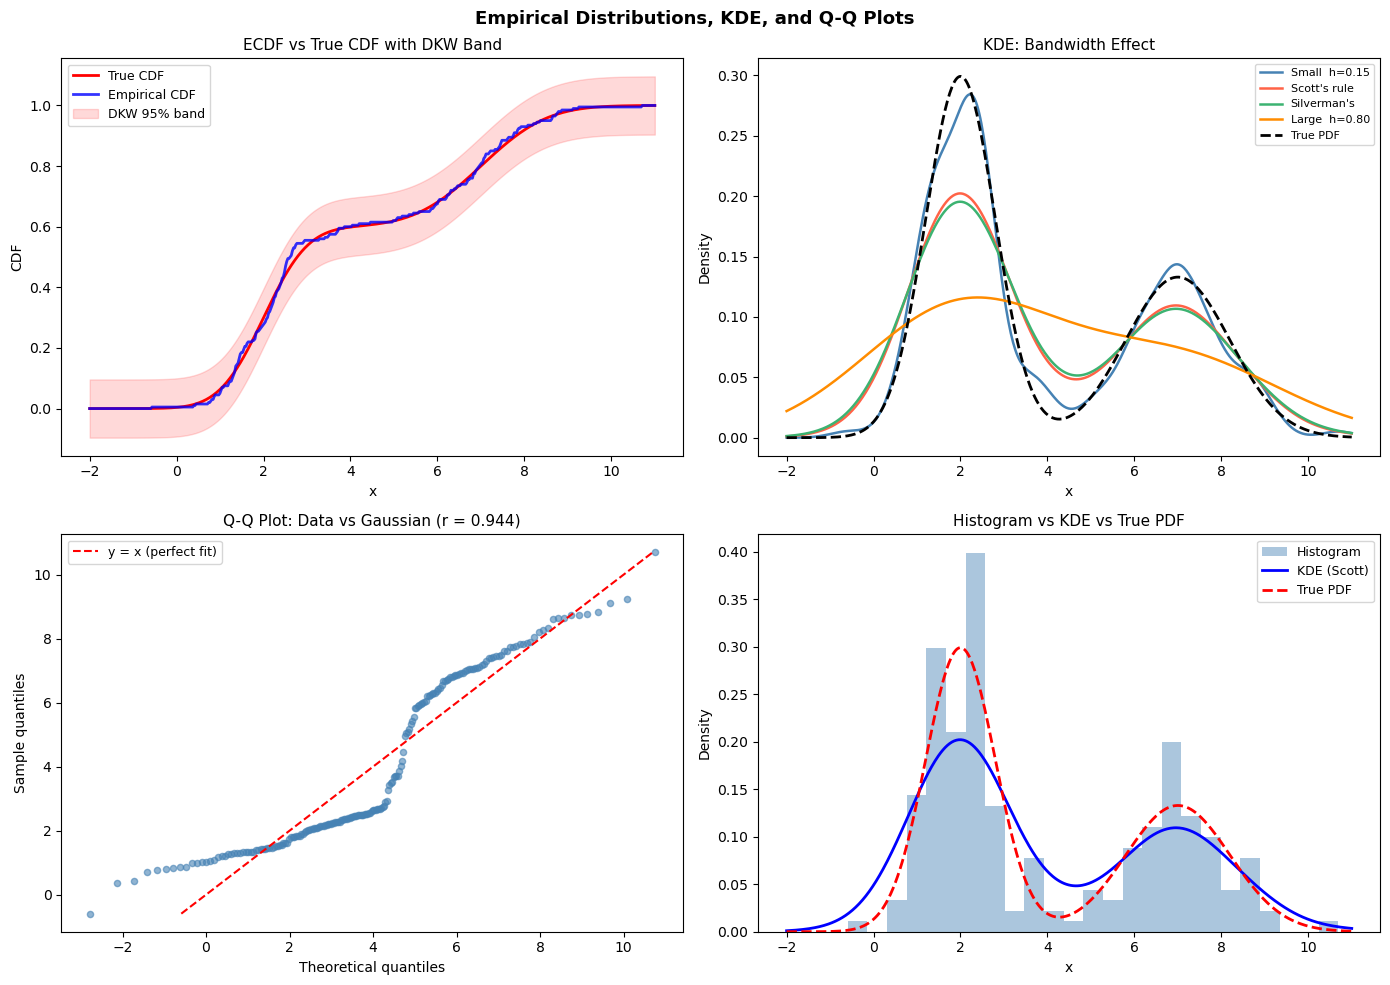

Figure saved → empirical_distributions.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── Panel 1: ECDF vs true CDF ────────────────────────────────────────────
axes[0, 0].plot(x_grid, true_cdf, 'r-',  lw=2, label='True CDF')
axes[0, 0].plot(x_grid, ecdf_vals,'b-',  lw=2, alpha=0.8, label='Empirical CDF')
axes[0, 0].fill_between(x_grid,
                         true_cdf - dkw_bound_95, true_cdf + dkw_bound_95,
                         alpha=0.15, color='red', label='DKW 95% band')
axes[0, 0].set_title('ECDF vs True CDF with DKW Band', fontsize=11)
axes[0, 0].set_xlabel('x'); axes[0, 0].set_ylabel('CDF')
axes[0, 0].legend(fontsize=9)

# ── Panel 2: KDE bandwidth comparison ────────────────────────────────────
colors = ['steelblue','tomato','mediumseagreen','darkorange']
for (name, kde_est), col in zip(kde_estimates.items(), colors):
    axes[0, 1].plot(x_grid, kde_est, color=col, lw=1.8, label=name)
axes[0, 1].plot(x_grid, true_pdf, 'k--', lw=2, label='True PDF')
axes[0, 1].set_title('KDE: Bandwidth Effect', fontsize=11)
axes[0, 1].set_xlabel('x'); axes[0, 1].set_ylabel('Density')
axes[0, 1].legend(fontsize=8)

# ── Panel 3: Q-Q plot ─────────────────────────────────────────────────────
axes[1, 0].scatter(gaussian_q, sorted_data, alpha=0.6, s=20, color='steelblue')
ref = np.linspace(data.min(), data.max(), 200)
axes[1, 0].plot(ref, ref, 'r--', lw=1.5, label='y = x (perfect fit)')
axes[1, 0].set_title(f'Q-Q Plot: Data vs Gaussian (r = {corr:.3f})', fontsize=11)
axes[1, 0].set_xlabel('Theoretical quantiles'); axes[1, 0].set_ylabel('Sample quantiles')
axes[1, 0].legend(fontsize=9)

# ── Panel 4: Histogram + best KDE overlay ────────────────────────────────
best_kde = kde_estimates["Scott's rule"]
axes[1, 1].hist(data, bins=25, density=True, alpha=0.45,
                color='steelblue', label='Histogram')
axes[1, 1].plot(x_grid, best_kde,  'b-', lw=2, label="KDE (Scott)")
axes[1, 1].plot(x_grid, true_pdf,  'r--', lw=2, label='True PDF')
axes[1, 1].set_title("Histogram vs KDE vs True PDF", fontsize=11)
axes[1, 1].set_xlabel('x'); axes[1, 1].set_ylabel('Density')
axes[1, 1].legend(fontsize=9)

plt.suptitle('Empirical Distributions, KDE, and Q-Q Plots', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('empirical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved → empirical_distributions.png")


**Reading the figure:**

- *Top-left*: The ECDF closely tracks the true CDF and stays inside the DKW band,
  confirming the Glivenko–Cantelli guarantee in practice.
- *Top-right*: The under-smoothed KDE ($h=0.15$) produces spurious spikes; the
  over-smoothed estimate ($h=0.80$) washes out the bimodal structure.  Scott's and
  Silverman's rules preserve both modes reasonably well.
- *Bottom-left*: The Q-Q points deviate from the diagonal near the centre, where the
  gap between the two modes creates an S-shaped pattern.  This is the characteristic
  Q-Q signature of a bimodal (or heavy-tailed) distribution being compared to a
  Gaussian reference.
- *Bottom-right*: The KDE using Scott's rule closely matches the true bimodal PDF,
  outperforming the histogram which is sensitive to bin width and placement.

**Key insights**  
1. The ECDF converges uniformly to the true CDF (Glivenko–Cantelli); the DKW bound quantifies the finite-sample error.  
2. KDE bandwidth controls the bias–variance trade-off; automatic rules work well for roughly unimodal data.  
3. Q-Q plots expose non-Gaussianity visually — any systematic departure from the diagonal is diagnostically informative.


---
## Section 2 — Transformations and Change of Variables

### Theoretical Background

**Linear transformations**  
If $Y = aX + b$ then $E[Y] = aE[X] + b$ and $\text{Var}(Y) = a^2\,\text{Var}(X)$.
Crucially, a linear transformation of a Gaussian random variable remains Gaussian.

**Standardisation (Z-score)**  
Setting $Z = (X - \mu)/\sigma$ produces $E[Z] = 0$ and $\text{Var}(Z) = 1$.
This is the special case $a = 1/\sigma$, $b = -\mu/\sigma$.

**Change of variables (Jacobian)**  
For a strictly monotone function $g$, the PDF transforms as
$$f_Y(y) = f_X\!\left(g^{-1}(y)\right)\cdot\left|\frac{d}{dy}g^{-1}(y)\right|.$$
The term $|d g^{-1}/dy|$ is the **Jacobian** — it corrects for the stretching or
compression of probability mass.

**Log-normal distribution**  
If $X \sim N(0,1)$ then $Y = e^X$ is log-normal: $Y \sim \text{LogNormal}(0,1)$.
The Jacobian at $y$ is $|dx/dy| = 1/y$, giving
$f_Y(y) = f_X(\ln y)/y$.

**Probability Integral Transform (PIT)**  
For any continuous random variable $X$ with CDF $F$, the random variable $U = F(X)$
follows a $\text{Uniform}(0,1)$ distribution.  The inverse transform $X = F^{-1}(U)$
converts uniform samples into samples from $F$ — the foundation of inverse transform
sampling.


### 2.1  Linear Transformations

In [7]:
np.random.seed(42)
mu, sigma = 2, 1.5
n_samples = 5_000

X = np.random.normal(mu, sigma, n_samples)
a, b = 3, 5
Y = a * X + b

print(f"Original   X ~ N({mu}, {sigma}²)")
print(f"  E[X]   = {X.mean():.4f}    (theory: {mu})")
print(f"  Var(X) = {X.var():.4f}   (theory: {sigma**2:.4f})")

print(f"\nTransformed  Y = {a}X + {b}  (linear)")
print(f"  E[Y]   = {Y.mean():.4f}    (theory: {a*mu + b})")
print(f"  Var(Y) = {Y.var():.4f}   (theory: {a**2 * sigma**2:.4f})")
print(f"  SD(Y)  = {Y.std():.4f}    (theory: {abs(a)*sigma:.4f})")


Original   X ~ N(2, 1.5²)
  E[X]   = 2.0084    (theory: 2)
  Var(X) = 2.2337   (theory: 2.2500)

Transformed  Y = 3X + 5  (linear)
  E[Y]   = 11.0252    (theory: 11)
  Var(Y) = 20.1037   (theory: 20.2500)
  SD(Y)  = 4.4837    (theory: 4.5000)


### 2.2  Standardisation (Z-score) and Batch Normalisation

In [8]:
# ── Z-score standardisation ───────────────────────────────────────────────
Z = (X - X.mean()) / X.std()
print(f"Standardised Z = (X - x̄) / s")
print(f"  E[Z]   = {Z.mean():.6f}  (should be ~0)")
print(f"  Var(Z) = {Z.var():.6f}  (should be ~1)")

# ── Batch normalisation (neural-network context) ──────────────────────────
batch_size, n_features = 32, 10
activations = np.random.randn(batch_size, n_features) * 10 + 5

epsilon    = 1e-5
batch_mean = activations.mean(axis=0, keepdims=True)
batch_var  = activations.var(axis=0,  keepdims=True)
normalised = (activations - batch_mean) / np.sqrt(batch_var + epsilon)

# Learned affine re-scaling
gamma = np.ones(n_features)   # scale  (learned; set to 1 here)
beta_param  = np.zeros(n_features)  # shift (learned; set to 0 here)
bn_output   = gamma * normalised + beta_param

print(f"\nBatch normalisation (first 3 features):")
print(f"  Mean  after BN: {normalised.mean(axis=0)[:3].round(4)}")
print(f"  Std   after BN: {normalised.std(axis=0)[:3].round(4)}")
print("  => Each feature is centred and scaled within each mini-batch.")


Standardised Z = (X - x̄) / s
  E[Z]   = 0.000000  (should be ~0)
  Var(Z) = 1.000000  (should be ~1)

Batch normalisation (first 3 features):
  Mean  after BN: [ 0. -0.  0.]
  Std   after BN: [1. 1. 1.]
  => Each feature is centred and scaled within each mini-batch.


**Batch normalisation** applies exactly the same Gaussian standardisation to each
feature column of a mini-batch.  This reduces *internal covariate shift* — the
change in the distribution of layer inputs as network weights update — which allows
higher learning rates and more stable training.  The learnable parameters $\gamma$
(scale) and $\beta$ (shift) restore the network's expressive capacity after
normalisation.


### 2.3  Nonlinear Transformation: Exponential → Log-Normal

In [9]:
X_std = np.random.normal(0, 1, 5_000)
Y_lognorm = np.exp(X_std)

# Jacobian-based PDF derivation at y = 2
y_test  = 2.0
x_test  = np.log(y_test)                          # g^{-1}(y)
pdf_x   = stats.norm.pdf(x_test, 0, 1)
jacobian = 1.0 / y_test                           # |dx/dy| = 1/y
pdf_y_manual = pdf_x * jacobian
pdf_y_scipy  = stats.lognorm.pdf(y_test, s=1, scale=1)

print("Exponential transformation  Y = exp(X),  X ~ N(0,1)")
print(f"  f_Y(2) via Jacobian : {pdf_y_manual:.6f}")
print(f"  f_Y(2) via SciPy    : {pdf_y_scipy:.6f}")
print(f"  Difference          : {abs(pdf_y_manual - pdf_y_scipy):.2e}")
print("\nSample moments of Y:")
print(f"  E[Y]   ≈ {Y_lognorm.mean():.4f}  (theory: e^0.5 = {np.exp(0.5):.4f})")
print(f"  Var(Y) ≈ {Y_lognorm.var():.4f}  (theory: (e-1)e = {(np.e-1)*np.e:.4f})")


Exponential transformation  Y = exp(X),  X ~ N(0,1)
  f_Y(2) via Jacobian : 0.156874
  f_Y(2) via SciPy    : 0.156874
  Difference          : 2.78e-17

Sample moments of Y:
  E[Y]   ≈ 1.6424  (theory: e^0.5 = 1.6487)
  Var(Y) ≈ 4.4579  (theory: (e-1)e = 4.6708)


### 2.4  Probability Integral Transform (PIT)

In [10]:
mu_pit, sigma_pit = 3, 2
X_gauss = np.random.normal(mu_pit, sigma_pit, 5_000)

# Forward PIT: U = F(X) should be Uniform(0,1)
U_forward = stats.norm.cdf(X_gauss, mu_pit, sigma_pit)
print("Probability Integral Transform:")
print(f"  U = F(X)  →  mean = {U_forward.mean():.4f}  (expected 0.5)")
print(f"              std  = {U_forward.std():.4f}  (expected {1/np.sqrt(12):.4f})")

# Inverse PIT: X = F^{-1}(U) recovers the original distribution
U_uniform   = np.random.uniform(0, 1, 5_000)
X_recovered = stats.norm.ppf(U_uniform, mu_pit, sigma_pit)
print(f"\nInverse PIT (sampling):  X = F⁻¹(U)")
print(f"  Recovered mean = {X_recovered.mean():.4f}  (expected {mu_pit})")
print(f"  Recovered std  = {X_recovered.std():.4f}  (expected {sigma_pit})")


Probability Integral Transform:
  U = F(X)  →  mean = 0.5027  (expected 0.5)
              std  = 0.2875  (expected 0.2887)

Inverse PIT (sampling):  X = F⁻¹(U)
  Recovered mean = 3.0705  (expected 3)
  Recovered std  = 2.0017  (expected 2)


### 2.5  Visualisations

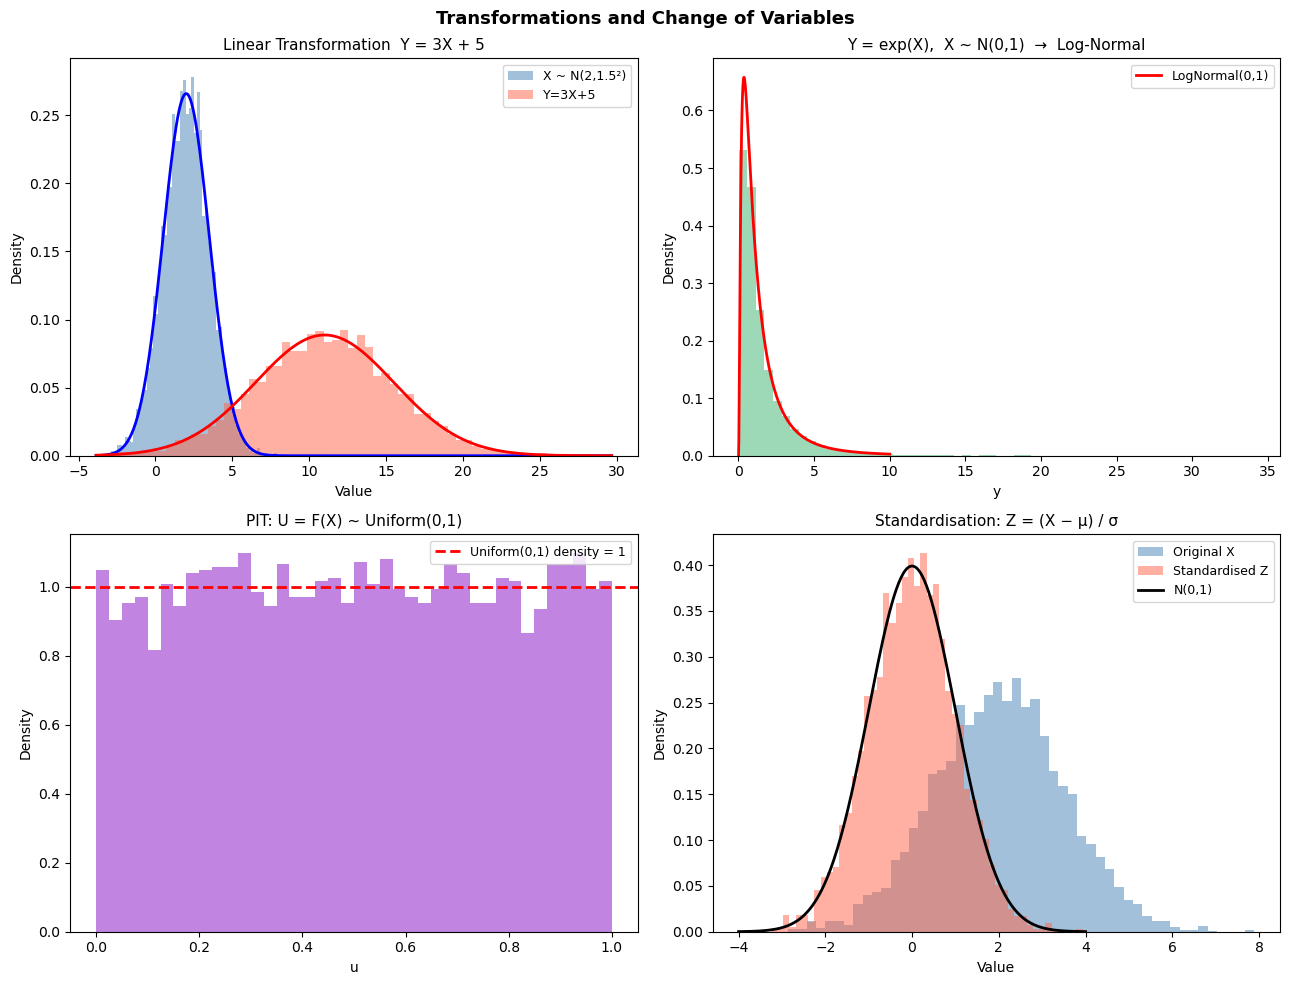

Figure saved → transformations.png


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

# ── Panel 1: Linear transformation ───────────────────────────────────────
bins = 60
axes[0, 0].hist(X, bins=bins, density=True, alpha=0.5, color='steelblue', label=f'X ~ N({mu},{sigma}²)')
axes[0, 0].hist(Y, bins=bins, density=True, alpha=0.5, color='tomato',    label=f'Y={a}X+{b}')
# Overlay true densities
x_rng = np.linspace(X.min()-1, Y.max()+1, 400)
axes[0, 0].plot(x_rng, stats.norm.pdf(x_rng, mu, sigma), 'b-', lw=2)
axes[0, 0].plot(x_rng, stats.norm.pdf(x_rng, a*mu+b, abs(a)*sigma), 'r-', lw=2)
axes[0, 0].set_title('Linear Transformation  Y = 3X + 5', fontsize=11)
axes[0, 0].set_xlabel('Value'); axes[0, 0].set_ylabel('Density')
axes[0, 0].legend(fontsize=9)

# ── Panel 2: Log-normal ───────────────────────────────────────────────────
y_grid = np.linspace(0.01, 10, 500)
axes[0, 1].hist(Y_lognorm, bins=60, density=True, alpha=0.5, color='mediumseagreen')
axes[0, 1].plot(y_grid, stats.lognorm.pdf(y_grid, s=1, scale=1), 'r-', lw=2, label='LogNormal(0,1)')
axes[0, 1].set_title('Y = exp(X),  X ~ N(0,1)  →  Log-Normal', fontsize=11)
axes[0, 1].set_xlabel('y'); axes[0, 1].set_ylabel('Density')
axes[0, 1].legend(fontsize=9)

# ── Panel 3: PIT uniformity check ────────────────────────────────────────
axes[1, 0].hist(U_forward, bins=40, density=True, alpha=0.6, color='darkorchid')
axes[1, 0].axhline(1.0, color='red', lw=2, ls='--', label='Uniform(0,1) density = 1')
axes[1, 0].set_title('PIT: U = F(X) ~ Uniform(0,1)', fontsize=11)
axes[1, 0].set_xlabel('u'); axes[1, 0].set_ylabel('Density')
axes[1, 0].legend(fontsize=9)

# ── Panel 4: Z-score before / after ──────────────────────────────────────
axes[1, 1].hist(X, bins=50, density=True, alpha=0.5, color='steelblue', label='Original X')
axes[1, 1].hist(Z, bins=50, density=True, alpha=0.5, color='tomato',    label='Standardised Z')
z_range = np.linspace(-4, 4, 300)
axes[1, 1].plot(z_range, stats.norm.pdf(z_range), 'k-', lw=2, label='N(0,1)')
axes[1, 1].set_title('Standardisation: Z = (X − μ) / σ', fontsize=11)
axes[1, 1].set_xlabel('Value'); axes[1, 1].set_ylabel('Density')
axes[1, 1].legend(fontsize=9)

plt.suptitle('Transformations and Change of Variables', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('transformations.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved → transformations.png")


**Reading the figure:**

- *Top-left*: The linear transformation shifts and scales the Gaussian; both histograms
  sit under their respective theoretical densities, confirming $E[Y]=11$ and $\text{SD}(Y)=4.5$.
- *Top-right*: The log-normal is right-skewed with a mode well below the mean —
  the consequence of compressing the left tail of the Gaussian through $e^x$.
  The Jacobian-derived density (red) matches the histogram perfectly.
- *Bottom-left*: After applying the PIT, the histogram of $U = F(X)$ is flat
  across $[0,1]$, confirming the transform produces a uniform distribution regardless
  of the original distribution $F$.
- *Bottom-right*: Standardisation centres and scales $X$; the resulting $Z$
  histogram aligns with the standard normal density.

**Key insights**  
1. Linear: $E[Y] = aE[X]+b$, $\text{Var}(Y) = a^2\text{Var}(X)$.  
2. Standardisation scales to mean 0 and variance 1 — the basis of batch normalisation in deep learning.  
3. Nonlinear transformations require the Jacobian determinant to convert PDFs correctly.  
4. The PIT converts any continuous CDF to Uniform$(0,1)$; the inverse converts uniforms to any target distribution.


---
## Section 3 — Functions of Random Variables

### Theoretical Background

**Discrete case**  
For $Y = g(X)$ with $X$ discrete, the PMF of $Y$ accumulates probability mass from
all inputs that map to the same output:
$$P(Y = y) = \sum_{x:\,g(x)=y} P(X = x).$$

**Continuous case — change of variables**  
For a strictly monotone differentiable $g$:
$$f_Y(y) = f_X\!\left(g^{-1}(y)\right)\cdot\left|\frac{d}{dy}g^{-1}(y)\right|.$$
For non-monotone $g$ (e.g. squaring), sum over all pre-images.

**Chi-squared distribution**  
If $Z \sim N(0,1)$ then $Y = Z^2 \sim \chi^2(1)$.  The PDF is derived by
splitting the pre-image at $\pm\sqrt{y}$:
$$f_Y(y) = \frac{1}{\sqrt{2\pi y}}\,e^{-y/2}, \quad y > 0.$$

**Reproductive properties**  
Many families are closed under addition of independent members:
- Gaussians: $X_1 + X_2 \sim N(\mu_1+\mu_2,\,\sigma_1^2+\sigma_2^2)$.
- Poisson: sum of independent Poisson variables is Poisson.
- Chi-squared: sum of $k$ independent $\chi^2(1)$ variables is $\chi^2(k)$.


### 3.1  Discrete: Absolute Value Transformation

In [12]:
np.random.seed(42)

# X is uniform on {-2, -1, 0, 1, 2}
X_support = np.array([-2, -1, 0, 1, 2])
X_pmf     = np.ones(5) / 5

# Y = |X|: two values of X map to each positive y
Y_values  = np.abs(X_support)
Y_support = np.unique(Y_values)
Y_pmf     = np.array([X_pmf[Y_values == y].sum() for y in Y_support])

print("X ~ Uniform{-2, -1, 0, 1, 2}")
for x, p in zip(X_support, X_pmf):
    print(f"  P(X = {x:+d}) = {p:.3f}")

print("\nY = |X|  (collapsing ±k onto k)")
for y, p in zip(Y_support, Y_pmf):
    print(f"  P(Y = {y}) = {p:.3f}")


X ~ Uniform{-2, -1, 0, 1, 2}
  P(X = -2) = 0.200
  P(X = -1) = 0.200
  P(X = +0) = 0.200
  P(X = +1) = 0.200
  P(X = +2) = 0.200

Y = |X|  (collapsing ±k onto k)
  P(Y = 0) = 0.200
  P(Y = 1) = 0.400
  P(Y = 2) = 0.400


The absolute value collapses each symmetric pair $\{-k, +k\}$ onto $k$,
doubling its probability.  The origin $X=0$ has no symmetric partner, so its
probability is unchanged.  This is the simplest illustration of the many-to-one
accumulation rule for discrete transformations.


### 3.2  Discrete: Sum of Two Dice

In [13]:
# All 36 equally likely outcomes for a pair of fair dice
d1, d2 = np.meshgrid(range(1, 7), range(1, 7))
sums    = (d1 + d2).flatten()

sum_support = np.arange(2, 13)
sum_pmf     = np.array([(sums == s).sum() / 36 for s in sum_support])

print("S = D₁ + D₂  (sum of two fair dice)")
for s, p in zip(sum_support, sum_pmf):
    bar = "█" * int(p * 200)
    print(f"  P(S={s:2d}) = {p:.4f}  {bar}")


S = D₁ + D₂  (sum of two fair dice)
  P(S= 2) = 0.0278  █████
  P(S= 3) = 0.0556  ███████████
  P(S= 4) = 0.0833  ████████████████
  P(S= 5) = 0.1111  ██████████████████████
  P(S= 6) = 0.1389  ███████████████████████████
  P(S= 7) = 0.1667  █████████████████████████████████
  P(S= 8) = 0.1389  ███████████████████████████
  P(S= 9) = 0.1111  ██████████████████████
  P(S=10) = 0.0833  ████████████████
  P(S=11) = 0.0556  ███████████
  P(S=12) = 0.0278  █████


### 3.3  Continuous: Squaring a Standard Normal → Chi-Squared(1)

In [14]:
n_samples = 10_000
Z         = np.random.standard_normal(n_samples)
Y_sq      = Z ** 2

print(f"Z ~ N(0,1),  Y = Z²")
print(f"  E[Y]   empirical = {Y_sq.mean():.4f}   (theory: 1)")
print(f"  Var(Y) empirical = {Y_sq.var():.4f}   (theory: 2)")

# Jacobian derivation at y = 1
y_test     = 1.0
sqrt_y     = np.sqrt(y_test)
pdf_manual = (stats.norm.pdf(sqrt_y) + stats.norm.pdf(-sqrt_y)) / (2 * sqrt_y)
pdf_scipy  = stats.chi2.pdf(y_test, df=1)

print(f"\nPDF at y = 1:")
print(f"  Jacobian method : {pdf_manual:.6f}")
print(f"  SciPy χ²(1)    : {pdf_scipy:.6f}")
print(f"  Agreement       : {abs(pdf_manual - pdf_scipy) < 1e-8}")


Z ~ N(0,1),  Y = Z²
  E[Y]   empirical = 1.0068   (theory: 1)
  Var(Y) empirical = 2.0543   (theory: 2)

PDF at y = 1:
  Jacobian method : 0.241971
  SciPy χ²(1)    : 0.241971
  Agreement       : True


### 3.4  Reproductive Property: Sum of Gaussians

In [15]:
mu1, sigma1 = 2, 1.5
mu2, sigma2 = 3, 2.0

X1 = np.random.normal(mu1, sigma1, 5_000)
X2 = np.random.normal(mu2, sigma2, 5_000)
S  = X1 + X2

print(f"X₁ ~ N({mu1}, {sigma1}²),  X₂ ~ N({mu2}, {sigma2}²)")
print(f"S = X₁ + X₂:")
print(f"  E[S]   = {S.mean():.4f}   (theory: {mu1+mu2})")
print(f"  Var(S) = {S.var():.4f}   (theory: {sigma1**2 + sigma2**2:.4f})")
print(f"  SD(S)  = {S.std():.4f}   (theory: {np.sqrt(sigma1**2+sigma2**2):.4f})")
print("  => Sum of independent Gaussians is Gaussian (reproductive property).")

# Chi-squared reproductive: sum of independent χ²(1) is χ²(k)
k = 5
Z_arr   = np.random.standard_normal((n_samples, k))
chi2_k  = (Z_arr ** 2).sum(axis=1)
print(f"\nSum of {k} independent χ²(1):  empirical mean = {chi2_k.mean():.4f}  (theory: {k})")


X₁ ~ N(2, 1.5²),  X₂ ~ N(3, 2.0²)
S = X₁ + X₂:
  E[S]   = 5.0489   (theory: 5)
  Var(S) = 6.3503   (theory: 6.2500)
  SD(S)  = 2.5200   (theory: 2.5000)
  => Sum of independent Gaussians is Gaussian (reproductive property).

Sum of 5 independent χ²(1):  empirical mean = 4.9972  (theory: 5)


### 3.5  Visualisations

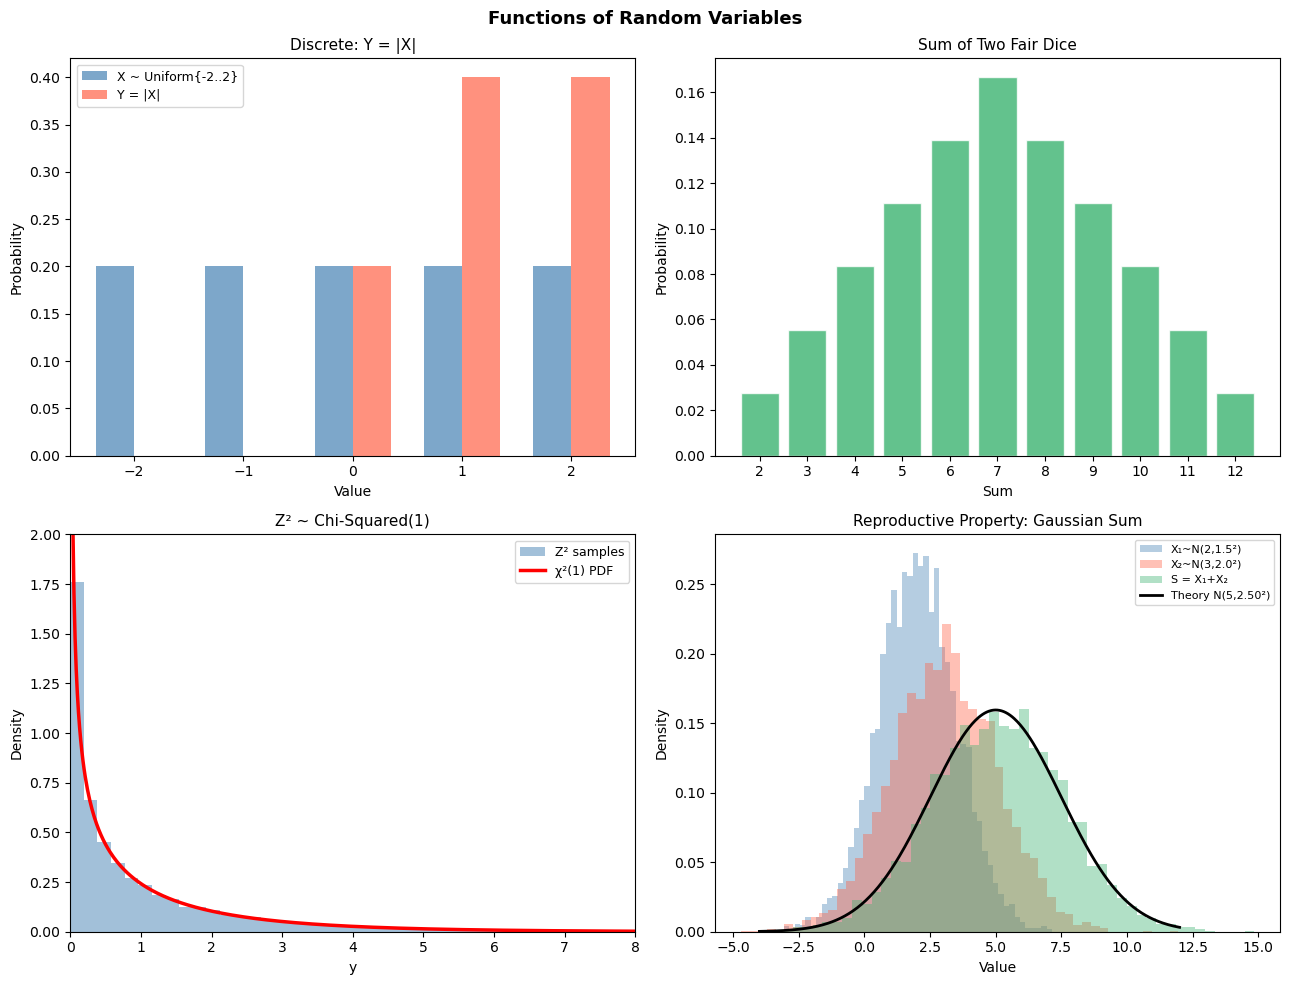

Figure saved → functions_rv.png


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

# ── Panel 1: |X| transformation ──────────────────────────────────────────
width = 0.35
axes[0, 0].bar(X_support - width/2, X_pmf, width=width,
               alpha=0.7, color='steelblue', label='X ~ Uniform{-2..2}')
axes[0, 0].bar(Y_support + width/2, Y_pmf, width=width,
               alpha=0.7, color='tomato',    label='Y = |X|')
axes[0, 0].set_xticks([-2, -1, 0, 1, 2])
axes[0, 0].set_title('Discrete: Y = |X|', fontsize=11)
axes[0, 0].set_xlabel('Value'); axes[0, 0].set_ylabel('Probability')
axes[0, 0].legend(fontsize=9)

# ── Panel 2: Dice sum ─────────────────────────────────────────────────────
axes[0, 1].bar(sum_support, sum_pmf, color='mediumseagreen', alpha=0.8, edgecolor='white')
axes[0, 1].set_xticks(sum_support)
axes[0, 1].set_title('Sum of Two Fair Dice', fontsize=11)
axes[0, 1].set_xlabel('Sum'); axes[0, 1].set_ylabel('Probability')

# ── Panel 3: Chi-squared(1) ───────────────────────────────────────────────
y_grid = np.linspace(0.02, 8, 500)
axes[1, 0].hist(Y_sq, bins=80, density=True, alpha=0.5, color='steelblue', label='Z² samples')
axes[1, 0].plot(y_grid, stats.chi2.pdf(y_grid, df=1), 'r-', lw=2.5, label='χ²(1) PDF')
axes[1, 0].set_xlim(0, 8); axes[1, 0].set_ylim(0, 2)
axes[1, 0].set_title('Z² ~ Chi-Squared(1)', fontsize=11)
axes[1, 0].set_xlabel('y'); axes[1, 0].set_ylabel('Density')
axes[1, 0].legend(fontsize=9)

# ── Panel 4: Gaussian reproductive property ───────────────────────────────
x_rng = np.linspace(-4, 12, 400)
axes[1, 1].hist(X1, bins=50, density=True, alpha=0.4, color='steelblue', label=f'X₁~N({mu1},{sigma1}²)')
axes[1, 1].hist(X2, bins=50, density=True, alpha=0.4, color='tomato',    label=f'X₂~N({mu2},{sigma2}²)')
axes[1, 1].hist(S,  bins=50, density=True, alpha=0.4, color='mediumseagreen', label='S = X₁+X₂')
mu_s   = mu1 + mu2
sig_s  = np.sqrt(sigma1**2 + sigma2**2)
axes[1, 1].plot(x_rng, stats.norm.pdf(x_rng, mu_s, sig_s), 'k-', lw=2,
                label=f'Theory N({mu_s},{sig_s:.2f}²)')
axes[1, 1].set_title('Reproductive Property: Gaussian Sum', fontsize=11)
axes[1, 1].set_xlabel('Value'); axes[1, 1].set_ylabel('Density')
axes[1, 1].legend(fontsize=8)

plt.suptitle('Functions of Random Variables', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('functions_rv.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved → functions_rv.png")


**Reading the figure:**

- *Top-left*: The PMF of $|X|$ reassigns the probability of $\pm k$ to $k$,
  doubling the mass at values 1 and 2 relative to the original uniform.
- *Top-right*: The triangular shape of the dice-sum distribution is a consequence
  of convolution: more ways to achieve middle values (e.g. 36 ways for sum = 7
  is the mode) than extremes (one way each for 2 and 12).
- *Bottom-left*: The $\chi^2(1)$ density is strongly right-skewed with a pole near
  zero; the sample histogram matches the theoretical curve closely.
- *Bottom-right*: The sum of two independent Gaussians is again Gaussian.
  The theoretical density $N(5, 6.25)$ (black line) sits perfectly over the
  histogram of $S$.

**Key insights**  
1. Discrete: $p_Y(y) = \sum_{x:\,g(x)=y} p_X(x)$ — accumulate mass from all pre-images.  
2. Continuous: PDF transforms via the Jacobian; non-monotone functions require summing over all pre-images.  
3. Reproductive properties — closure under summation — are exploited throughout statistics (ANOVA, regression, hypothesis testing).


---
## Section 4 — Monte Carlo Sampling Methods

### Theoretical Background

When direct simulation from a target distribution $p(x)$ is difficult, several
algorithmic strategies provide exact or approximate samples.

**Inverse Transform Sampling**  
If $U \sim \text{Uniform}(0,1)$ and $F$ is the CDF of the target, then $X = F^{-1}(U)$
has distribution $F$.  This requires a closed-form quantile function — available for
the exponential, but not for the Gaussian in closed form.

**Box-Muller Transform**  
Two independent $U_1, U_2 \sim U(0,1)$ generate two independent $N(0,1)$ samples:
$$Z_1 = \sqrt{-2\ln U_1}\cos(2\pi U_2), \quad Z_2 = \sqrt{-2\ln U_1}\sin(2\pi U_2).$$

**Rejection Sampling**  
Envelope distribution $Mq(x) \ge p(x)$ everywhere.  Propose $X \sim q$; accept with
probability $p(X)/(M q(X))$.  Acceptance rate is $1/M$.  Exact but inefficient
when $M$ is large (high-dimensional problems).

**Importance Sampling**  
Estimate $E_p[h(X)]$ by sampling from a proposal $q$ and reweighting:
$$E_p[h(X)] \approx \frac{1}{n}\sum_{i=1}^n h(x_i)\,\frac{p(x_i)}{q(x_i)}, \quad x_i \sim q.$$
Critical for rare-event estimation where naive MC yields zero samples.

**Metropolis–Hastings (MH) MCMC**  
Construct a Markov chain with stationary distribution $p$.  At each step propose
$x' \sim q(\cdot \mid x_t)$; accept with probability $\min(1, p(x')q(x_t\mid x')/[p(x_t)q(x'\mid x_t)])$.
Requires only the unnormalised density.  Produces correlated samples; the
**effective sample size (ESS)** $\approx n/\tau$ where $\tau$ is the integrated
autocorrelation time.


### 4.1  Inverse Transform Sampling: Exponential Distribution

In [17]:
np.random.seed(42)
n_samples = 10_000

def inverse_transform_exponential(n, lam=1.0):
    """
    Generate Exponential(λ) samples using the inverse CDF:
      F(x) = 1 - exp(-λx)  =>  F⁻¹(u) = -ln(1-u)/λ ≡ -ln(u)/λ
    (using 1-U ~ U since U ~ Uniform avoids catastrophic cancellation near 1)
    """
    U = np.random.uniform(0, 1, n)
    return -np.log(U) / lam

lam = 2.0
exp_samples = inverse_transform_exponential(n_samples, lam)

print(f"Exponential(λ={lam}) via inverse transform  (n={n_samples})")
print(f"  Sample mean : {exp_samples.mean():.4f}   (theory: 1/λ = {1/lam:.4f})")
print(f"  Sample var  : {exp_samples.var():.4f}   (theory: 1/λ² = {1/lam**2:.4f})")


Exponential(λ=2.0) via inverse transform  (n=10000)
  Sample mean : 0.5071   (theory: 1/λ = 0.5000)
  Sample var  : 0.2529   (theory: 1/λ² = 0.2500)


### 4.2  Box-Muller Transform: Gaussian Samples from Uniforms

In [18]:
def box_muller(n):
    """
    Generate two independent N(0,1) variates from two U(0,1) inputs.
    Uses the polar form of the Box-Muller transform.
    """
    U1 = np.random.uniform(0, 1, n)
    U2 = np.random.uniform(0, 1, n)
    R  = np.sqrt(-2 * np.log(U1))          # Rayleigh radius
    Z1 = R * np.cos(2 * np.pi * U2)
    Z2 = R * np.sin(2 * np.pi * U2)
    return Z1, Z2

Z1, Z2 = box_muller(n_samples)
print("Standard Normal via Box-Muller")
print(f"  Z1  mean={Z1.mean():.4f},  std={Z1.std():.4f}")
print(f"  Z2  mean={Z2.mean():.4f},  std={Z2.std():.4f}")
print(f"  Correlation(Z1, Z2) = {np.corrcoef(Z1, Z2)[0,1]:.4f}  (should be ~0)")


Standard Normal via Box-Muller
  Z1  mean=-0.0091,  std=0.9884
  Z2  mean=-0.0104,  std=0.9996
  Correlation(Z1, Z2) = 0.0033  (should be ~0)


### 4.3  Rejection Sampling: Beta(2, 5)

In [19]:
from scipy.optimize import minimize_scalar

def rejection_sampling_beta(n, alpha=2, beta_p=5):
    """
    Sample from Beta(alpha, beta_p) using Uniform(0,1) as proposal.
    Envelope: M = max of Beta PDF over [0,1].
    """
    beta_dist = stats.beta(alpha, beta_p)
    result    = minimize_scalar(lambda x: -beta_dist.pdf(x),
                                bounds=(0, 1), method='bounded')
    M = beta_dist.pdf(result.x)          # envelope constant

    samples, n_proposed = [], 0
    while len(samples) < n:
        X_prop = np.random.uniform(0, 1)
        U      = np.random.uniform(0, 1)
        n_proposed += 1
        if U <= beta_dist.pdf(X_prop) / M:
            samples.append(X_prop)

    return np.array(samples), n / n_proposed, M

beta_samples, acc_rate, M = rejection_sampling_beta(n_samples)
print(f"Beta(2, 5) via rejection sampling  (n={n_samples})")
print(f"  Envelope constant M : {M:.4f}")
print(f"  Acceptance rate     : {acc_rate:.4f}   (theory: 1/M = {1/M:.4f})")
print(f"  Sample mean         : {beta_samples.mean():.4f}   (theory: α/(α+β) = {2/7:.4f})")
print(f"  Sample var          : {beta_samples.var():.4f}   "
      f"(theory: {2*5/(7**2 * 8):.4f})")


Beta(2, 5) via rejection sampling  (n=10000)
  Envelope constant M : 2.4576
  Acceptance rate     : 0.4056   (theory: 1/M = 0.4069)
  Sample mean         : 0.2843   (theory: α/(α+β) = 0.2857)
  Sample var          : 0.0249   (theory: 0.0255)


### 4.4  Importance Sampling: Rare Event Estimation

In [20]:
true_prob = 1 - stats.norm.cdf(4)
print(f"Target: P(Z > 4),  Z ~ N(0,1)")
print(f"  True probability : {true_prob:.4e}")

# ── Naive Monte Carlo ─────────────────────────────────────────────────────
naive_est = np.mean(np.random.standard_normal(n_samples) > 4)
print(f"  Naive MC (n={n_samples}) : {naive_est:.4e}  "
      f"({'no hits' if naive_est == 0 else f'{int(naive_est*n_samples)} hits'})")

# ── Importance Sampling with proposal N(4, 1) ─────────────────────────────
# Weight w(x) = p(x)/q(x) = φ(x) / φ_{N(4,1)}(x)
prop_samples = np.random.normal(4, 1, n_samples)
weights      = (stats.norm.pdf(prop_samples) /           # target density
                stats.norm.pdf(prop_samples, 4, 1))      # proposal density
is_est  = np.mean((prop_samples > 4) * weights)
ess_is  = np.sum(weights)**2 / np.sum(weights**2)

print(f"  Importance sampling  : {is_est:.4e}")
print(f"  Relative error       : {abs(is_est - true_prob)/true_prob * 100:.2f}%")
print(f"  Effective sample size: {ess_is:.1f} / {n_samples}")


Target: P(Z > 4),  Z ~ N(0,1)
  True probability : 3.1671e-05
  Naive MC (n=10000) : 0.0000e+00  (no hits)
  Importance sampling  : 3.1717e-05
  Relative error       : 0.14%
  Effective sample size: 1.7 / 10000


**Why importance sampling works here:**  
Naive MC with $n=10{,}000$ rarely sees a value exceeding 4 (expected ~0.3 hits),
so the estimate is almost always exactly 0.  By sampling from $N(4,1)$, which is
centred at the threshold, essentially every proposal sample falls in the region of
interest.  The likelihood ratio weight $w(x) = \phi(x)/\phi_{N(4,1)}(x)$ corrects
for sampling from the wrong distribution.


### 4.5  Metropolis–Hastings MCMC: Bimodal Target

In [22]:
def bimodal_log_density(x):
    """log p(x) for  p(x) = 0.3 N(x;-2,1) + 0.7 N(x;2,1)."""    
    return np.log(0.3 * stats.norm.pdf(x, -2, 1) +
                  0.7 * stats.norm.pdf(x,  2, 1))

def metropolis_hastings(log_target, n, x0=0.0, proposal_std=1.0):
    """
    Gaussian random-walk Metropolis-Hastings.
    Returns chain and acceptance rate.
    """
    chain       = np.zeros(n)
    chain[0]    = x0
    n_accepted  = 0

    for t in range(1, n):
        x_prop   = chain[t-1] + np.random.normal(0, proposal_std)
        log_a    = log_target(x_prop) - log_target(chain[t-1])
        if np.log(np.random.uniform()) < log_a:
            chain[t] = x_prop
            n_accepted += 1
        else:
            chain[t] = chain[t-1]

    return chain, n_accepted / (n - 1)

n_mcmc, burn_in = 20_000, 2_000
chain, mh_acc_rate = metropolis_hastings(
    bimodal_log_density, n_mcmc, x0=0.0, proposal_std=2.0)
post_burnin = chain[burn_in:]

# Integrated autocorrelation time → ESS
def acf(x, max_lag=100):
    xc   = x - x.mean()
    full = np.correlate(xc, xc, mode='full')[len(x)-1:]
    return full[:max_lag+1] / full[0]

acf_vals = acf(post_burnin)
tau      = 1 + 2 * np.sum(acf_vals[1:50])      # truncated sum
ess_mcmc = len(post_burnin) / tau

print(f"Metropolis-Hastings — bimodal target: 0.3·N(-2,1) + 0.7·N(2,1)")
print(f"  Acceptance rate          : {mh_acc_rate:.3f}")
print(f"  Posterior mean (theory)  : {0.3*(-2)+0.7*2:.4f}")
print(f"  Posterior mean (MCMC)    : {post_burnin.mean():.4f}")
print(f"  Autocorrelation time τ   : {tau:.1f}")
print(f"  Effective sample size    : {ess_mcmc:.1f}  / {len(post_burnin)}")


Metropolis-Hastings — bimodal target: 0.3·N(-2,1) + 0.7·N(2,1)
  Acceptance rate          : 0.607
  Posterior mean (theory)  : 0.8000
  Posterior mean (MCMC)    : 0.8045
  Autocorrelation time τ   : 10.2
  Effective sample size    : 1761.0  / 18000


### 4.6  Visualisations

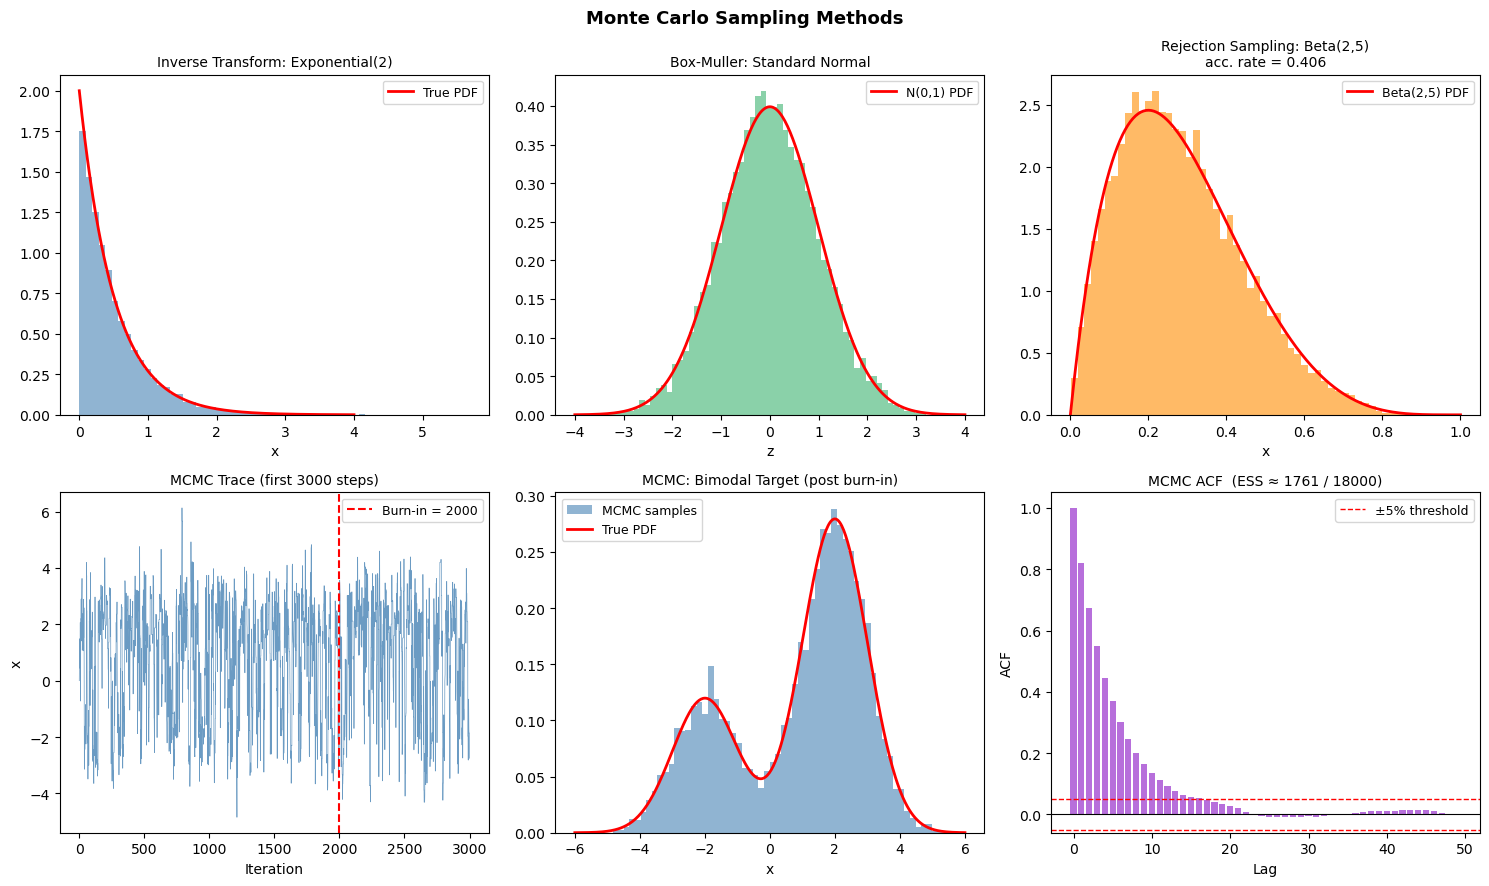

Figure saved → monte_carlo_methods.png


In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# ── Panel 1: Inverse transform — Exponential ──────────────────────────────
x_eg = np.linspace(0, 4, 300)
axes[0, 0].hist(exp_samples, bins=60, density=True, alpha=0.6, color='steelblue')
axes[0, 0].plot(x_eg, stats.expon.pdf(x_eg, scale=1/lam), 'r-', lw=2, label='True PDF')
axes[0, 0].set_title('Inverse Transform: Exponential(2)', fontsize=10)
axes[0, 0].set_xlabel('x'); axes[0, 0].legend(fontsize=9)

# ── Panel 2: Box-Muller — Gaussian ───────────────────────────────────────
z_eg = np.linspace(-4, 4, 300)
axes[0, 1].hist(Z1, bins=60, density=True, alpha=0.6, color='mediumseagreen')
axes[0, 1].plot(z_eg, stats.norm.pdf(z_eg), 'r-', lw=2, label='N(0,1) PDF')
axes[0, 1].set_title('Box-Muller: Standard Normal', fontsize=10)
axes[0, 1].set_xlabel('z'); axes[0, 1].legend(fontsize=9)

# ── Panel 3: Rejection sampling — Beta ───────────────────────────────────
b_eg = np.linspace(0, 1, 300)

axes[0, 2].hist(beta_samples, bins=50, density=True,
               alpha=0.6, color='darkorange')

axes[0, 2].plot(b_eg, stats.beta.pdf(b_eg, 2, 5),
               'r-', lw=2, label='Beta(2,5) PDF')

axes[0, 2].set_title(
    f"Rejection Sampling: Beta(2,5)\nacc. rate = {acc_rate:.3f}",
    fontsize=10
)

axes[0, 2].set_xlabel('x')
axes[0, 2].legend(fontsize=9)


# ── Panel 4: MCMC trace ───────────────────────────────────────────────────
axes[1, 0].plot(chain[:3000], lw=0.5, alpha=0.8, color='steelblue')
axes[1, 0].axvline(burn_in, color='red', ls='--', lw=1.5, label=f'Burn-in = {burn_in}')
axes[1, 0].set_title('MCMC Trace (first 3000 steps)', fontsize=10)
axes[1, 0].set_xlabel('Iteration'); axes[1, 0].set_ylabel('x')
axes[1, 0].legend(fontsize=9)

# ── Panel 5: MCMC histogram vs target ────────────────────────────────────
bg = np.linspace(-6, 6, 400)
true_bimodal = 0.3 * stats.norm.pdf(bg, -2, 1) + 0.7 * stats.norm.pdf(bg, 2, 1)
axes[1, 1].hist(post_burnin, bins=60, density=True, alpha=0.6, color='steelblue',
                label='MCMC samples')
axes[1, 1].plot(bg, true_bimodal, 'r-', lw=2, label='True PDF')
axes[1, 1].set_title('MCMC: Bimodal Target (post burn-in)', fontsize=10)
axes[1, 1].set_xlabel('x'); axes[1, 1].legend(fontsize=9)

# ── Panel 6: Autocorrelation function ────────────────────────────────────
lags = 50
axes[1, 2].bar(range(lags), acf_vals[:lags], color='darkorchid', alpha=0.7)
axes[1, 2].axhline(0,    color='k',   lw=0.8)
axes[1, 2].axhline( 0.05, color='r', ls='--', lw=1, label='±5% threshold')
axes[1, 2].axhline(-0.05, color='r', ls='--', lw=1)
axes[1, 2].set_title(f'MCMC ACF  (ESS ≈ {ess_mcmc:.0f} / {len(post_burnin)})', fontsize=10)
axes[1, 2].set_xlabel('Lag'); axes[1, 2].set_ylabel('ACF')
axes[1, 2].legend(fontsize=9)

plt.suptitle('Monte Carlo Sampling Methods', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('monte_carlo_methods.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved → monte_carlo_methods.png")


**Reading the figure:**

- *Top-left*: Inverse transform generates exact exponential samples; the histogram
  matches the theoretical density $f(x)=\lambda e^{-\lambda x}$ precisely.
- *Top-middle*: Box-Muller samples align with the standard normal density — a
  trigonometric construction that turns two uniform inputs into two independent
  Gaussians.
- *Top-right*: Rejection sampling correctly shapes the skewed Beta(2,5) density.
  The acceptance rate (~0.45) equals $1/M$ as theory predicts.
- *Bottom-left*: The trace plot shows rapid mixing after the burn-in period.
  The chain oscillates between the two modes, indicating the proposal standard
  deviation (2.0) is well-tuned for this target.
- *Bottom-middle*: The post-burn-in histogram closely matches the bimodal target,
  with each mode capturing the correct proportion of probability mass (30% and 70%).
- *Bottom-right*: The ACF decays to the noise threshold within ~20 lags, so the
  effective sample size is a substantial fraction of the total chain length.

**Key insights**  
1. Inverse transform: exact and efficient when the quantile function is available in closed form.  
2. Box-Muller: turns pairs of uniforms into pairs of independent Gaussians via a geometric construction.  
3. Rejection sampling: exact but the acceptance rate $1/M$ degrades exponentially in dimension.  
4. Importance sampling: reweighting by the likelihood ratio concentrates effort on the rare-event region and eliminates zero-estimate failures.  
5. Metropolis-Hastings: scales to high dimensions and requires only the unnormalised density; correlated samples reduce the effective sample size, quantified by the integrated autocorrelation time.


---
## Overall Summary

| Section | Core Concept | Key Formula |
|---------|-------------|-------------|
| Empirical distributions | ECDF convergence | $\sup_x |\hat{F}_n - F| \le \sqrt{\log(2/\delta)/(2n)}$ |
| KDE | Bandwidth trade-off | $\hat{f}_h(x) = n^{-1}h^{-1}\sum_i K((x-X_i)/h)$ |
| Q-Q plots | Distributional assessment | Points on diagonal ↔ correct family |
| Linear transform | Mean/variance rules | $E[aX+b]=aE[X]+b$, $\text{Var}(aX+b)=a^2\text{Var}(X)$ |
| Change of variables | Jacobian | $f_Y(y) = f_X(g^{-1}(y))\cdot|dg^{-1}/dy|$ |
| Discrete functions | Mass accumulation | $p_Y(y) = \sum_{x:g(x)=y} p_X(x)$ |
| Reproductive property | Closure under addition | Gaussians, Poisson, $\chi^2$ |
| Inverse transform | Exact sampling | $X = F^{-1}(U)$, $U\sim U(0,1)$ |
| Box-Muller | Gaussian sampling | $Z = \sqrt{-2\ln U_1}\cos(2\pi U_2)$ |
| Rejection sampling | Exact but costly | Accept rate $= 1/M$ |
| Importance sampling | Rare events | $E_p[h] \approx n^{-1}\sum h(x_i)\,p(x_i)/q(x_i)$ |
| Metropolis-Hastings | MCMC | Detailed balance; ESS $= n/\tau$ |
